# LangGraph ReAct Agent with Tools

### Learning Objectives:
* Create tools (functions) that LLMs can call
* Implement the ReAct pattern (Reasoning + Acting)
* Build an agent that decides when to use tools

# Real-World Tools:
* Database Queries
* API calls (weather, stock prices, etc.)
* File Operations
* Web Searches
* Send emails/notifications
* Execute code
* Image generation
* Data Analysis

# Agent Patterns

* Chain of Thoughts
* Tree of Thoughts
* ReAct

In [15]:
# Imports and Ollama setup
from typing_extensions import TypedDict, Annotated
import operator
from langchain_openai import ChatOpenAI
from langgraph.graph import START, END, StateGraph
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.prebuilt import ToolNode
import os
from dotenv import load_dotenv
load_dotenv()

BASE_URL="https://api.groq.com/openai/v1"
MODEL_NAME="openai/gpt-oss-20b"

def groq_llm():
    return ChatOpenAI(
        model=MODEL_NAME,
        base_url=BASE_URL,
        api_key=os.getenv("GROQ_API_KEY"),
        temperature=0.5
    )

llm = groq_llm()

### Reducer
a reducer function takes in the datatype and action to be taken and it does it

In [16]:
class AgentState(TypedDict):
    messages: Annotated[list, operator.add]

### Agent Node
A langgraph workflow is called an agent only when tools are attched to the LLM

In [17]:
# Importing Tools
import my_tools

In [18]:
all_tools = [my_tools.get_weather, my_tools.calculate]
all_tools

[StructuredTool(name='get_weather', description='Retrieve the current weather for a given location.\n\nThis function is intended to be used as a LangGraph tool. It accepts\nsimple, serializable inputs and returns a JSON-serializable dictionary\ndescribing current weather conditions.\n\nArgs:\n    location (str): The name of the city or geographic location\n        (e.g., "San Francisco", "Paris", "Tokyo").\n    unit (str, optional): Temperature unit to use. Supported values\n        are "celsius" and "fahrenheit". Defaults to "celsius".\n\nReturns:\n    dict: A dictionary containing weather information with the\n    following keys:\n        - location (str): Resolved location name\n        - temperature (float): Current temperature in the requested unit\n        - unit (str): Temperature unit ("celsius" or "fahrenheit")\n        - condition (str): Short textual description of the weather\n          (e.g., "clear", "rain", "cloudy")\n\nRaises:\n    ValueError: If the location is empty o

In [19]:
## Agent Node
def agent_node(state: AgentState):
    llm_with_tools = llm.bind_tools(all_tools)
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    if hasattr(response, 'tool_calls') and response.tool_calls:
        for tc in response.tool_calls:
            print(f"[AGENT] called Tool: {tc.get('name', '?')} with args {tc.get('args', '?')}")
    else:
        print(f"[AGENT] Responding...")
    return {"messages": [response]}

In [20]:
state = {"messages": [HumanMessage("HI")]}
result = agent_node(state)

[AGENT] Responding...


In [21]:
result

{'messages': [AIMessage(content='Hello! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 39, 'prompt_tokens': 719, 'total_tokens': 758, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 21, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': None, 'queue_time': 0.048284261, 'prompt_time': 0.036677439, 'completion_time': 0.045065893, 'total_time': 0.081743332}, 'model_provider': 'openai', 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_e99e93f2ac', 'id': 'chatcmpl-10493976-fb56-456c-a922-97529e60f0ed', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019be723-a96a-76c0-8240-8a1d1de0114d-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 719, 'output_tokens': 39, 'total_tokens': 758, 'input_token_details': {}, 'output_token_details': {'reasoning': 21}})]}

In [22]:
state = {"messages": [HumanMessage("Hi, what is 2+2?")]}
result = agent_node(state)
result

[AGENT] called Tool: calculate with args {'expression': '2+2'}


{'messages': [AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 727, 'total_tokens': 760, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 9, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': None, 'queue_time': 0.053243014, 'prompt_time': 0.036307126, 'completion_time': 0.033091399, 'total_time': 0.069398525}, 'model_provider': 'openai', 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_e99e93f2ac', 'id': 'chatcmpl-f5926795-46ab-494a-a15c-6189606284e0', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019be723-acf9-7ad3-9af6-0031f17dee13-0', tool_calls=[{'name': 'calculate', 'args': {'expression': '2+2'}, 'id': 'fc_a2aca840-20ca-4405-a805-6330ef20dcf5', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 727, 'output_tokens': 33, 'total_tokens': 760, '

### Routing for Tools

In [23]:
def should_continue(state: AgentState):
    last_message = state['messages'][-1]
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"
    else:
        return END

In [24]:
def create_agent():
    builder = StateGraph(AgentState)
    builder.add_node("agent", agent_node)
    builder.add_node("tools", ToolNode(all_tools))

    builder.add_edge(START, "agent")
    builder.add_conditional_edges("agent", should_continue, ["tools", END])
    builder.add_edge("tools", "agent")

    graph = builder.compile()
    return graph

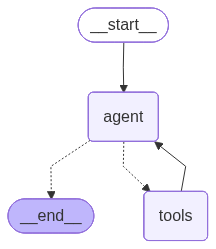

In [25]:
graph = create_agent()
graph

In [27]:
query = "calculate: 2+2*3/4"
result = graph.invoke({"messages": [HumanMessage(query)]})

[AGENT] called Tool: calculate with args {'expression': '2+2*3/4'}
[TOOL] calculate ('2+2*3/4') -> '3.5'
[AGENT] Responding...


In [28]:
result

{'messages': [HumanMessage(content='calculate: 2+2*3/4', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 728, 'total_tokens': 783, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 27, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': None, 'queue_time': 0.046976364, 'prompt_time': 0.046774536, 'completion_time': 0.058349365, 'total_time': 0.105123901}, 'model_provider': 'openai', 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_e99e93f2ac', 'id': 'chatcmpl-7a722e45-950b-47ca-bdf0-ce298299ba28', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019be727-664b-7950-a606-c92452b8d441-0', tool_calls=[{'name': 'calculate', 'args': {'expression': '2+2*3/4'}, 'id': 'fc_db78b20d-b2cd-480e-806e-9bc414809722', 'type': 'tool_call'}], invalid_